In [1]:
# Importing files 
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from io import BytesIO
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
import os
import cv2

In [2]:
folder_path = 'AdobeHackathon/problems'
os.chdir(folder_path)

In [3]:
folder_path = '.'
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

In [4]:
for file_path in csv_files:
    print(file_path)

./frag01_sol.csv
./frag2_sol.csv
./frag1.csv
./occlusion1_sol.csv
./occlusion2.csv
./occlusion1.csv
./occlusion2_sol.csv
./frag0.csv
./isolated.csv
./frag2.csv
./isolated_sol.csv


In [5]:
# Reading csv file
def read_csv(csv_path="/problems/isolated.csv"):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [6]:
def group_segments_by_curve(csv_file, tolerance=1e-5):


    df = pd.read_csv(csv_file, header=None)
    df.columns = ['segment_no', 'sub_segment', 'x', 'y']

  
    segments = []
    for segment_no in df['segment_no'].unique():
        segment_df = df[df['segment_no'] == segment_no]
        for sub_segment in segment_df['sub_segment'].unique():
            sub_segment_df = segment_df[segment_df['sub_segment'] == sub_segment]
            x_start = sub_segment_df['x'].values[0]
            y_start = sub_segment_df['y'].values[0]
            x_end = sub_segment_df['x'].values[-1]
            y_end = sub_segment_df['y'].values[-1]
            start_point = (x_start, y_start)
            end_point = (x_end, y_end)
            segments.append(((segment_no, sub_segment), start_point, end_point))

    closed_curves = []
    open_curves = []

    def points_match(point1, point2, tol):
        return np.linalg.norm(np.array(point1) - np.array(point2)) < tol

    for i in range(len(segments)):
        current_segment = segments[i]
        cur_segment_id = current_segment[0] 
        cur_start_point = current_segment[1]
        cur_end_point = current_segment[2]

        added_to_curve = False

        for curve in open_curves:
            first_segment_id = curve[0]
            last_segment_id = curve[-1]

            first_segment = next(seg for seg in segments if seg[0] == first_segment_id)
            last_segment = next(seg for seg in segments if seg[0] == last_segment_id)

            if points_match(last_segment[2], cur_start_point, tolerance):
                curve.append(cur_segment_id)
                added_to_curve = True
                if points_match(first_segment[1], cur_end_point, tolerance):
                    closed_curves.append(curve)
                    open_curves.remove(curve)
                break
            elif points_match(first_segment[1], cur_end_point, tolerance):
                curve.insert(0, cur_segment_id)
                added_to_curve = True
                if points_match(first_segment[1], cur_start_point, tolerance):
                    closed_curves.append(curve)
                    open_curves.remove(curve)
                break

        if not added_to_curve:
            if points_match(cur_start_point, cur_end_point, tolerance):
                closed_curves.append([cur_segment_id])
            else:
                open_curves.append([cur_segment_id])

    return segments, closed_curves, open_curves

In [7]:
def extract_all_points_from_curve(curve, csv_file):
    df = pd.read_csv(csv_file, header=None)
    df.columns = ['segment_no', 'sub_segment', 'x', 'y']

    curve_set = set(curve)

    curve_segments = df[df.apply(lambda row: (row['segment_no'], row['sub_segment']) in curve_set, axis=1)]

    points = curve_segments[['x', 'y']].values.tolist()
    return points

# Main logic of Code

In [8]:
def check_straight_line(points, tolerance):

    if len(points) < 2:
        return True  
        
    X = np.array([p[0] for p in points]).reshape(-1, 1)
    y = np.array([p[1] for p in points])
    model = LinearRegression().fit(X, y)
    slope, intercept = model.coef_[0], model.intercept_

    deviations = np.abs(np.array([p[1] for p in points]) - (slope * np.array([p[0] for p in points]) + intercept))

    return np.all(deviations < tolerance)

In [9]:
def regularize_open_curves(csv_file, open_curves, tolerance=2, verbose=True):
    
    open_plots = []
    for curve in open_curves:
        points = extract_all_points_from_curve(curve, csv_file)
        x = [p[0] for p in points]
        y = [p[1] for p in points]

        if len(y) > 5:  
            y_smoothed = savgol_filter(y, window_length=5, polyorder=2)
        else:
            y_smoothed = y

        if check_straight_line(points, tolerance):
            if verbose:
                print("Line detected")
            st_line_points = [x[0], y[0], x[-1], y[-1]]
            open_plots.append([st_line_points, "Line"])
        else:
            open_plots.append([points, "Irregular"])

    return open_plots

In [10]:
def identify_shapes(contour):

    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if area < 500:
        return None

    M = cv2.moments(contour)
    if M["m00"] == 0:  
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    shape_name = "Irregular"
    if len(approx) == 3:
        shape_name = "Triangle"
    elif len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.99 <= aspect_ratio <= 1.01:
            shape_name = "Square"
        else:
            shape_name = "Rectangle"
    elif len(approx) > 4:
        distances = [np.sqrt((cx - p[0][0])**2 + (cy - p[0][1])**2) for p in contour]

        peaks = (np.diff(np.sign(np.diff(distances))) == -2).nonzero()[0] + 1
        valleys = (np.diff(np.sign(np.diff(distances))) == 2).nonzero()[0] + 1

        mean_dist = np.mean(distances)
        max_dist_deviation = 0.15 * mean_dist  
        if all(abs(d - mean_dist) < max_dist_deviation for d in distances):
            shape_name = "Circle"
        elif len(approx) == 10 and abs(len(peaks) - len(valleys)) <= 2:
            shape_name = "Star"
        else:
            if len(contour) >= 5:
                ellipse = cv2.fitEllipse(contour)
                (center, axes, orientation) = ellipse
                major_axis, minor_axis = max(axes), min(axes)
                axis_ratio = minor_axis / major_axis

                focal_distance = np.sqrt(major_axis**2 - minor_axis**2) / 2
                angle_rad = np.deg2rad(orientation)
                focal1 = (int(center[0] + focal_distance * np.cos(angle_rad)),
                          int(center[1] + focal_distance * np.sin(angle_rad)))
                focal2 = (int(center[0] - focal_distance * np.cos(angle_rad)),
                          int(center[1] - focal_distance * np.sin(angle_rad)))

                sum_distances = []
                for p in contour:
                    d1 = np.linalg.norm(np.array(p[0]) - np.array(focal1))
                    d2 = np.linalg.norm(np.array(p[0]) - np.array(focal2))
                    sum_distances.append(d1 + d2)

                max_deviation = 0.1 * np.mean(sum_distances)
                if max(sum_distances) - min(sum_distances) <= max_deviation:
                    shape_name = "Ellipse"
                    
    return {'shape': shape_name, 'approx': approx}

In [11]:
def plot_curve(curve):

    fig, ax = plt.subplots(figsize=(8, 8))

    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')

    points = curve[0]
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    ax.plot(x, y, 'o', color='black', markersize=5)
    x_min = min(x_min, *x)
    x_max = max(x_max, *x)
    y_min = min(y_min, *y)
    y_max = max(y_max, *y)

   

    ax.set_xlim(x_min - 10, x_max + 10)
    ax.set_ylim(y_min - 10, y_max + 10)
    ax.set_aspect('equal')
    ax.axis('off')  
    return fig, ax

In [12]:
def regularize_closed_curves(csv_file, closed_curves, margin, verbose=True):

    final_closed_plots = []
    for curve in closed_curves:
        points = extract_all_points_from_curve(curve, csv_file)
        adjusted_points = [[x + margin, y + margin] for x, y in points]
        closed_plot = [adjusted_points, "Original"]

        fig, ax = plot_curve(closed_plot)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)  # Close the figure to free memory

        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        _, thresh_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        i = 0

        for contour in contours:
            if i == 0:
                i = 1
                continue
            if i > 1:
                continue
            M = cv2.moments(contour)
            if M["m00"] == 0:  
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroid = (cx, cy)

            shape_info = identify_shapes(contour)
            if shape_info:
                if shape_info['shape'] in ["Triangle", "Square", "Rectangle", "Circle", "Ellipse", "Star"]:
                    final_closed_plots.append([points, shape_info['shape']])
                    if verbose:
                        print(f"{shape_info['shape']} detected")
                else:
                    final_closed_plots.append([points, "Irregular"])
            i += 1

    return final_closed_plots

In [13]:
def regularize(csv_file, verbose=True):

    segments, closed_curves, open_curves = group_segments_by_curve(csv_file, tolerance=1)

    margin = 100  
    closed_plots = []
    open_plots = []

    if closed_curves:
      
        closed_plots = regularize_closed_curves(csv_file, closed_curves, margin, verbose=verbose)

    if open_curves:

        open_plots = regularize_open_curves(csv_file, open_curves, verbose=verbose)

   
    all_plots = closed_plots + open_plots

    return all_plots

In [14]:
def regularize_circle(points):
    x_avg, y_avg = np.mean(points, axis=0)
    distances = np.linalg.norm(points - [x_avg, y_avg], axis=1)
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)

    if std_distance / mean_distance < 0.1:
        radius = mean_distance
        angles = np.linspace(0, 2 * np.pi, len(points))
        circle_points = np.array([[x_avg + radius * np.cos(angle), y_avg + radius * np.sin(angle)] for angle in angles])
        return circle_points
    return points

def get_regularized_image(plot_list, filename="regularized_image.png", padding=0.5):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')

    for curve in plot_list:
        points, shape_name = curve
        points = np.array(points)

        if shape_name == "Line":
            x_start, y_start, x_end, y_end = points.flatten()
            ax.plot([x_start, x_end], [y_start, y_end], color='black', linewidth=3)

        elif shape_name == "Triangle":
            centroid_x = np.mean(points[:, 0])
            centroid_y = np.mean(points[:, 1])
            distances = np.linalg.norm(points - [centroid_x, centroid_y], axis=1)
            mean_distance = np.mean(distances)
            angles = np.linspace(0, 2 * np.pi, 4)[:-1]
            triangle_points = [[centroid_x + mean_distance * np.cos(angle), centroid_y + mean_distance * np.sin(angle)] for angle in angles]
            triangle_points = np.array(triangle_points)
            ax.plot(triangle_points[:, 0], triangle_points[:, 1], color='black', linewidth=3)
            ax.plot([triangle_points[-1, 0], triangle_points[0, 0]], [triangle_points[-1, 1], triangle_points[0, 1]], color='black', linewidth=3)

        elif shape_name == "Circle":
            circle_points = regularize_circle(points)
            ax.plot(circle_points[:, 0], circle_points[:, 1], color='black', linewidth=3)
            ax.plot([circle_points[-1, 0], circle_points[0, 0]], [circle_points[-1, 1], circle_points[0, 1]], color='black', linewidth=3)

        elif shape_name == "Ellipse":
            centroid_x = np.mean(points[:, 0])
            centroid_y = np.mean(points[:, 1])
            centered_points = points - [centroid_x, centroid_y]
            covariance_matrix = np.cov(centered_points, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
            major_axis_length = 2 * np.sqrt(eigenvalues[1])
            minor_axis_length = 2 * np.sqrt(eigenvalues[0])
            angle = np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1])
            ellipse = plt.Ellipse([centroid_x, centroid_y], major_axis_length, minor_axis_length, np.degrees(angle), color='black', linewidth=3, fill=False)
            ax.add_patch(ellipse)

        elif shape_name in ["Rectangle", "Square"]:
            x_min, y_min = np.min(points, axis=0)
            x_max, y_max = np.max(points, axis=0)
            width = x_max - x_min
            height = y_max - y_min
            centroid_x = (x_min + x_max) / 2
            centroid_y = (y_min + y_max) / 2
            rect = plt.Rectangle((centroid_x - width / 2, centroid_y - height / 2), width, height, color='black', linewidth=3, fill=False)
            ax.add_patch(rect)

        elif shape_name == "Star":
            centroid_x = np.mean(points[:, 0])
            centroid_y = np.mean(points[:, 1])
            distances = np.linalg.norm(points - [centroid_x, centroid_y], axis=1)
            sorted_indices = np.argsort(distances)
            sorted_points = points[sorted_indices]
            num_peaks = 5
            num_valleys = 5
            peaks = sorted_points[-num_peaks:]
            valleys = sorted_points[:num_valleys]
            mean_peak_distance = np.mean([np.linalg.norm(p - [centroid_x, centroid_y]) for p in peaks])
            mean_valley_distance = np.mean([np.linalg.norm(v - [centroid_x, centroid_y]) for v in valleys])
            num_points = num_peaks + num_valleys
            angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
            star_points = []
            for i, angle in enumerate(angles):
                if i % 2 == 0:
                    x = centroid_x + mean_peak_distance * np.cos(angle)
                    y = centroid_y + mean_peak_distance * np.sin(angle)
                    star_points.append([x, y])
                else:
                    x = centroid_x + mean_valley_distance * np.cos(angle)
                    y = centroid_y + mean_valley_distance * np.sin(angle)
                    star_points.append([x, y])
            star_points = np.array(star_points)
            ax.plot(star_points[:, 0], star_points[:, 1], color='black', linewidth=3)
            ax.plot([star_points[-1, 0], star_points[0, 0]], [star_points[-1, 1], star_points[0, 1]], color='black', linewidth=3)

        else:
            ax.plot(points[:, 0], points[:, 1], '.', color='black', linewidth=2)

    ax.set_aspect('equal', 'box')

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=padding)
    plt.close(fig)

    buf.seek(0)
    image = PILImage.open(buf)
    image_path = filename
    image.save(image_path)
    return image_path


In [15]:
def plot_side_by_side(csv_file):

    base_name = os.path.splitext(os.path.basename(csv_file))[0]

    original_paths = read_csv(csv_file)

    regularized_plots = regularize(csv_file)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  
    ax1 = axes[0]
    for XYs in original_paths:
        for XY in XYs:
            ax1.plot(XY[:, 0], XY[:, 1], c='k', linewidth=3)
    ax1.set_aspect('equal')
    ax1.axis('off')  
    ax1.set_title("Original Image")

    ax2 = axes[1]
    regularized_image_path = get_regularized_image(regularized_plots, filename = f"{base_name}_regularized.png", padding=0)
    regularized_image = cv2.imread(regularized_image_path)
    ax2.imshow(regularized_image)
    ax2.axis('off')  
    ax2.set_title("Regularized Image")

    plt.show()


# From here code will run

/tmp/ipykernel_19581/2853527041.py:12: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_19581/2853527041.py:12: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Circle detected
Rectangle detected


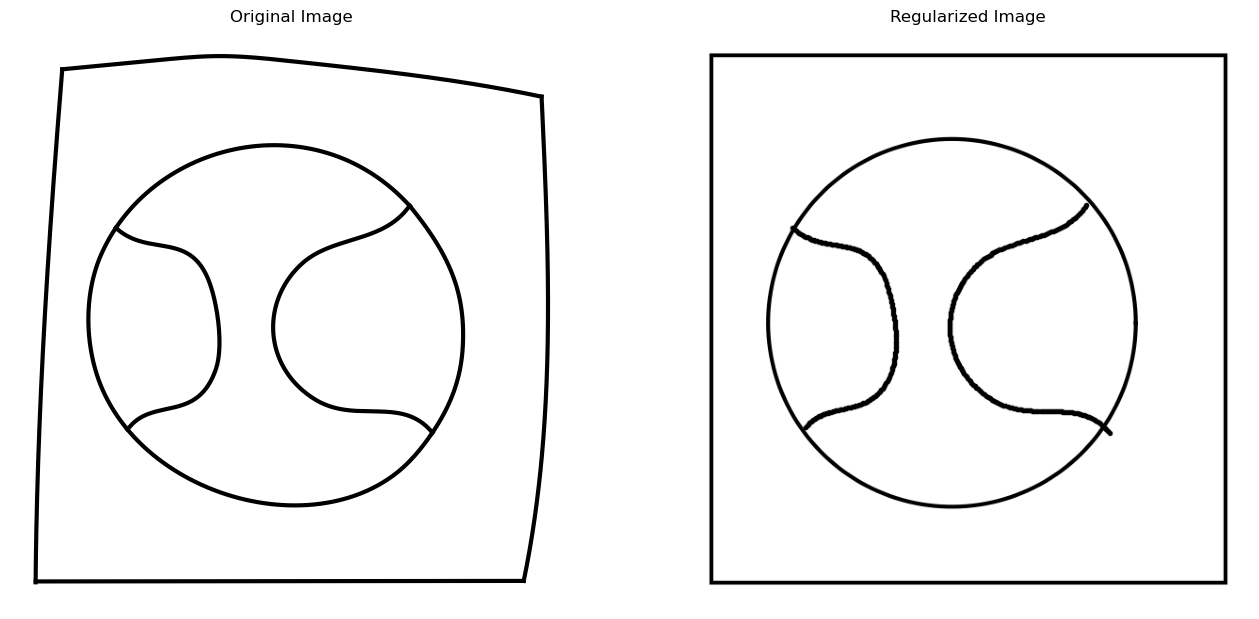

In [16]:
plot_side_by_side("frag0.csv")

/tmp/ipykernel_19581/2853527041.py:12: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_19581/2853527041.py:12: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_19581/2853527041.py:12: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Circle detected
Star detected
Rectangle detected


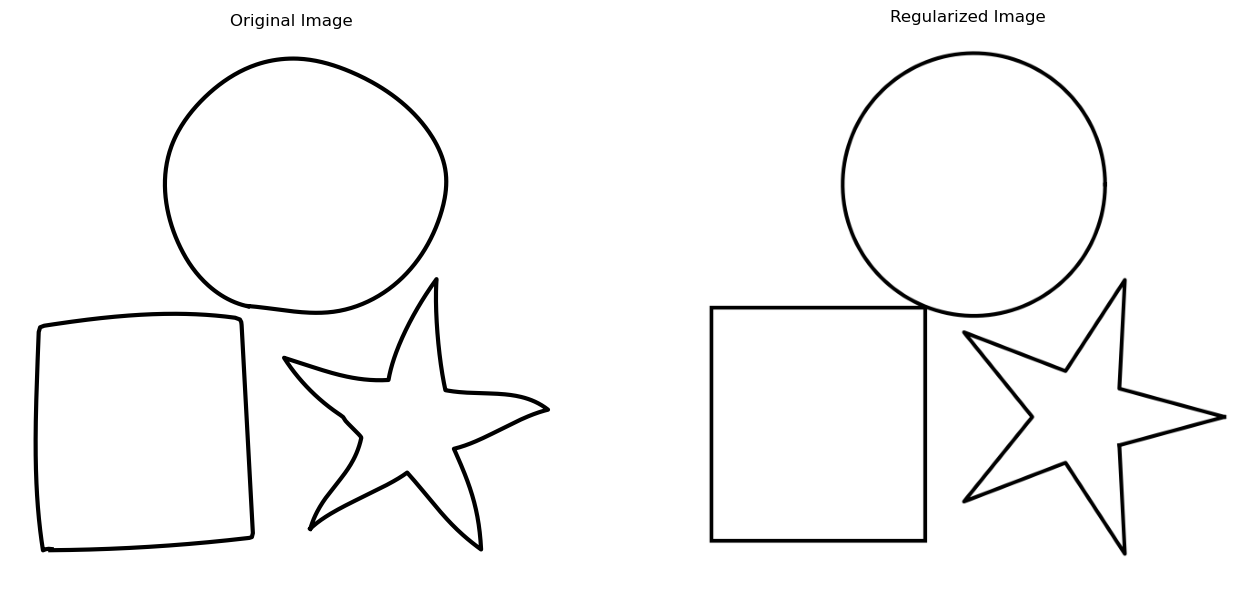

In [17]:
plot_side_by_side("isolated.csv")